In [1]:
%matplotlib notebook
%matplotlib inline

import os
import math, time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader
import stock_data_preprocessing

In [13]:
data = pd.read_csv('csv/gpro.csv')
del data['Name']
data.head()

,Date,Time,Open,High,Low,Current_Close,Volume
0,1/6/17,6:30:00,9.14,9.15,9.13,9.13,74484
1,1/6/17,6:45:00,9.15,9.25,9.01,9.10,534528
2,1/6/17,7:00:00,9.11,9.12,9.04,9.09,223794
3,1/6/17,7:15:00,9.08,9.09,9.00,9.03,491085
4,1/6/17,7:30:00,9.02,9.10,9.01,9.05,224747


In [18]:
data = data.drop(['Date', 'Open', 'High', 'Low', 'Volume'], axis=1)
data.head()

,Time,Current_Close
0,6:30:00,9.13
1,6:45:00,9.10
2,7:00:00,9.09
3,7:15:00,9.03
4,7:30:00,9.05


In [19]:
data.to_csv('gopro_formatted.csv')

In [4]:
# Shifts the close so that we can predict the next days target value 'Future Close'
data['Future_Close'] = data['Current_Close'].shift(-1)
data.tail()

,Date,Time,Open,High,Low,Current_Close,Volume,Future_Close
805,2/17/17,12:00:00,9.23,9.24,9.21,9.22,36674,9.22
806,2/17/17,12:15:00,9.22,9.23,9.18,9.22,74216,9.21
807,2/17/17,12:30:00,9.21,9.22,9.19,9.21,54399,9.21
808,2/17/17,12:45:00,9.21,9.22,9.19,9.21,46141,9.25
809,2/17/17,13:00:00,9.21,9.25,9.20,9.25,335658,NaN


In [7]:
min_data = data.min()
max_data = data.max()
data_adj = data
data_adj['Normalized_High'] = data["High"]/(max_data["High"] - min_data["High"])
data_adj['Normalized_Low'] = data["Low"]/(max_data["Low"] - min_data["Low"])
data_adj['Normalized_Open'] = data["Open"]/(max_data["Open"] - min_data["Open"])
data_adj['Normalized_Volume'] = data["Volume"]/(max_data["Volume"] - min_data["Volume"])
data_adj['Normalized_Current_Close'] = data["Current_Close"]/(max_data["Current_Close"] - min_data["Current_Close"])
data_adj['Normalized_Future_Close'] = data["Future_Close"]/(max_data["Future_Close"] - min_data["Future_Close"])

data_adj = data_adj.drop(['Date', 'Time', 'Open', 'High', 'Low', 'Current_Close', 'Volume', 'Future_Close'], axis=1)
prediction_features = data_adj.tail(1)

# Remove the last row since we don't have a Target Value
data_adj = data_adj[:-1]
data_adj.tail()

,Normalized_High,Normalized_Low,Normalized_Open,Normalized_Volume,Normalized_Current_Close,Normalized_Future_Close
804,3.886555,3.873950,3.886555,0.007790,3.873950,3.873950
805,3.882353,3.869748,3.878151,0.013241,3.873950,3.873950
806,3.878151,3.857143,3.873950,0.026795,3.873950,3.869748
807,3.873950,3.861345,3.869748,0.019640,3.869748,3.869748
808,3.873950,3.861345,3.869748,0.016659,3.869748,3.886555


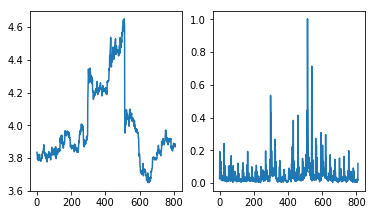

In [5]:
ax0 = plt.subplot2grid((6,2),(0,0),rowspan=5, colspan=1)
ax1 = plt.subplot2grid((6,2),(0,1),rowspan=5, colspan=1)
    
ax0.plot(data.index,data['Normalized_Current_Close'])
ax1.plot(data.index,data['Normalized_Volume'])
plt.show()

In [22]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    print(data.shape)
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index:index + sequence_length])

    result = np.array(result)
    # 90% of Total
    row = round(0.9 * result.shape[0])
    
    train = result[:int(row), :]
    np.random.shuffle(train)
    print(' ========== ')
    print(train.shape)
    x_train = train[:, :, :-1]
    print(x_train.shape)
    print(' ========== ')
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :, :-1]
    y_test = result[int(row):, -1][:,-1]

    # Last window we need to predict for the next interval
    future_pred = result[result.shape[0]-1:, :, :-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features-1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features-1))  

    return [x_train, y_train, x_test, y_test, future_pred]

In [23]:
window = 22
X_train, y_train, X_test, y_test, future_pred = load_data(data_adj[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print("future_pred", future_pred.shape)

(809, 6)
(707, 23, 6)
(707, 23, 5)
('X_train', (707, 23, 5))
('y_train', (707,))
('X_test', (79, 23, 5))
('y_test', (79,))
('future_pred', (1, 23, 5))


In [35]:
print(y_train)

print(future_pred)
d = future_pred[0][:]
#d = np.vstack([d, prediction_features.as_matrix()])
#print(d.shape[0])
#print(d.shape[1])

fp = np.reshape(d, (1, d.shape[0], d.shape[1]))
print(fp.shape)

[ 4.40336134  3.94117647  4.44537815  3.83613445  4.34453782  3.9789916
  4.03361345  3.95378151  3.82352941  3.88235294  3.73529412  4.21428571
  4.46638655  3.86554622  3.69327731  4.          4.57983193  3.87815126
  4.22268908  4.01260504  3.90756303  3.8487395   4.10084034  3.85294118
  4.03781513  4.21848739  3.86134454  3.71008403  4.50420168  4.29831933
  3.88235294  3.91596639  3.86134454  3.95798319  4.43277311  3.70168067
  3.97478992  4.47058824  3.8697479   3.86134454  3.80672269  3.95798319
  3.71848739  3.84453782  4.46638655  4.50420168  3.70168067  3.83613445
  3.85294118  4.18907563  4.22689076  3.72268908  4.20168067  3.92857143
  3.9789916   4.00840336  3.71428571  4.52941176  3.83613445  4.46638655
  3.94957983  3.97478992  3.82773109  3.84033613  3.93277311  3.88235294
  3.71428571  3.92436975  4.26890756  3.84033613  4.22689076  3.90336134
  3.81092437  4.03781513  3.95378151  4.60504202  3.88235294  3.95798319
  4.21008403  3.95378151  3.84033613  4.14705882  4.

In [25]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

In [26]:
#Step 2 Build Model
model = Sequential()
print(X_train.shape[-1])

model.add(LSTM(
    input_dim=X_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

5
compilation time : 0.0317168235779


In [45]:
#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=100,
    nb_epoch=200,
    validation_split=0.05)

Train on 671 samples, validate on 36 samples
Epoch 1/200
671/671 [==============================] - 1s - loss: 0.1477 - val_loss: 0.0855
Epoch 2/200
671/671 [==============================] - 1s - loss: 0.1447 - val_loss: 0.0778
Epoch 3/200
671/671

In [46]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(trainScore)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

0.00198442467297
Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.00 MSE (0.01 RMSE)


In [29]:
print(X_test.shape)

(79, 23, 5)


In [36]:
print(future_pred.shape)

(1, 23, 5)


In [47]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [48]:
f = model.predict(fp)

In [49]:
print(f)

[[ 3.82148552]]


In [50]:
print(f*(max_data["Future_Close"] - min_data["Future_Close"]))

[[ 9.09513569]]


In [51]:
print(y_test*(max_data["Future_Close"] - min_data["Future_Close"]))

[ 9.02  9.04  9.06  9.07  9.06  9.09  9.07  9.09  9.06  9.09  9.12  9.14
  9.13  9.11  9.08  9.05  9.07  9.08  9.09  9.08  9.04  8.99  9.01  9.02
  9.02  9.07  9.04  9.06  9.11  9.1   9.11  9.08  9.12  9.12  9.08  9.12
  9.12  9.13  9.16  9.19  9.24  9.17  9.18  9.15  9.14  9.13  9.12  9.14
  9.09  9.07  9.04  9.08  9.08  9.1   9.07  9.02  9.02  9.01  9.    9.02
  9.02  9.03  9.02  9.02  9.02  9.05  9.1   9.06  9.03  9.05  9.04  9.02
  9.01  9.04  9.1   9.07  9.05  9.03  9.09]


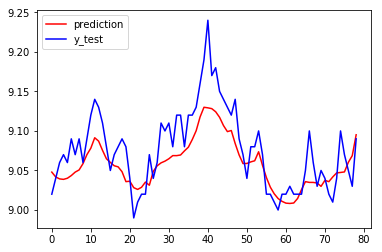

In [52]:
import matplotlib.pyplot as plt2
plt2.plot(p*(max_data["Future_Close"] - min_data["Future_Close"]),color='red', label='prediction')
plt2.plot(y_test*(max_data["Future_Close"] - min_data["Future_Close"]),color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()